In [174]:
import pandas as pd
import numpy as np
import datetime
import requests
from requests.auth import HTTPBasicAuth
import tarfile
import os
import shutil
import warnings
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

#keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout,Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.models import Model,Sequential 
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [185]:
def get_organize_files(): 
    #download files with images
    #https://talhassner.github.io/home/projects/Adience/Adience-data.html
    print('starting download')
    BASE_URL = "http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification"
    DOWNLOAD_FILES = {
              "http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/aligned.tar.gz": "aligned.tar.gz",
              "http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/fold_0_data.txt": "fold_0_data.txt",
              "http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/fold_1_data.txt": "fold_1_data.txt",
              "http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/fold_2_data.txt": "fold_2_data.txt",
              "http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/fold_3_data.txt": "fold_3_data.txt",
              "http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/fold_4_data.txt": "fold_4_data.txt"
                    }

    for DOWNLOAD_FILE, FILE_NAME in DOWNLOAD_FILES.items():
        if not os.path.exists(FILE_NAME):
            with open(FILE_NAME, 'wb') as file:
                r = requests.get(DOWNLOAD_FILE, auth = HTTPBasicAuth('adiencedb', 'adience'))
                file.write(r.content)
                print('downloaded {}'.format(FILE_NAME))
    
    print('unziping images...')
    
    if not os.path.exists('aligned'):
        with tarfile.open('aligned.tar.gz') as file:
            file.extractall()
        
    print('images unziped')
    
    #compile all files catalog
    fold = pd.read_csv('fold_0_data.txt',sep='\t')
    fold.rename(columns={' user_id':'user_id'},inplace=True)
    fold['fold'] = 0
    for i in range(1,5):
        temp = pd.read_csv('fold_'+str(i)+'_data.txt',sep='\t')
        temp['fold'] = i
        fold = fold.append(temp,ignore_index=True)

    fold.dropna(subset=['gender'],inplace=True)
    fold = fold[['user_id','original_image','face_id','age','gender','fold']]
     
    train = fold.groupby('gender',as_index=False,group_keys=False).apply(lambda x: x.sample(frac=.5))
    test = fold.drop(train.index.values)
    
    print('Train and test split done')
    
    #creates directories for training, test and validation files
    cwd = os.getcwd()
    
    train_faces = os.path.join(cwd,'train')
    if not os.path.exists(train_faces):
        os.mkdir(train_faces)
    
    test_faces = os.path.join(cwd,'test')
    if not os.path.exists(test_faces):
        os.mkdir(test_faces)
    
    #copy images to each directory
    for index, row in train.iterrows():
        src = os.path.join(cwd,'aligned',row['user_id'],'landmark_aligned_face.'+str(row['face_id'])+'.'+row['original_image'])
        dst = os.path.join(train_faces,row['original_image'])
        shutil.copyfile(src,dst)

    print('train images copied')

    for index, row in test.iterrows():
        src = os.path.join(cwd,'aligned',row['user_id'],'landmark_aligned_face.'+str(row['face_id'])+'.'+row['original_image'])
        dst = os.path.join(test_faces,row['original_image'])
        shutil.copyfile(src,dst)

    print('test images copied')
    
    return train,test


In [186]:
train_images_ids, test_images_ids = get_organize_files()

starting download
unziping images...
images unziped
Train and test split done
train images copied
test images copied


In [182]:
def Model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape = (150, 150, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Conv2D(32, (1, 1), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Flatten())
    model.add(Dense(units = 192, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 3, activation = 'softmax'))
    model.compile(loss='categorical_crossentropy', optimazer = optimizers.RMSprop(lr=1e-4), metrics=['acc'])
    
    return model

In [187]:
#vectorizing images 
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
                    train_images_ids,
                    x_col='original_image',
                    y_col='gender',
                    directory=train_faces,
                    target_size=(150,150),
                    batch_size=20,
                    class_mode='categorical'
                )

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
                    test_images_ids,
                    x_col='original_image',
                    y_col='gender',
                    directory=test_faces,
                    target_size=(150,150),
                    batch_size=20,
                    class_mode='categorical'
                )

Found 9296 validated image filenames belonging to 3 classes.
Found 9295 validated image filenames belonging to 3 classes.


In [188]:
#training model
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=15,
                              validation_data = test_generator,
                              validation_steps=30)
model.save('face_gender_detection.h5')

Epoch 1/15
100/100 [==============================] - 93s 932ms/step - loss: 0.8281 - acc: 0.6090 - val_loss: 0.7463 - val_acc: 0.6583
Epoch 2/15
100/100 [==============================] - 92s 920ms/step - loss: 0.7399 - acc: 0.6280 - val_loss: 0.7475 - val_acc: 0.6233
Epoch 3/15
100/100 [==============================] - 92s 923ms/step - loss: 0.7303 - acc: 0.6355 - val_loss: 0.7335 - val_acc: 0.6517
Epoch 4/15
100/100 [==============================] - 92s 918ms/step - loss: 0.7109 - acc: 0.6493 - val_loss: 0.7139 - val_acc: 0.6633
Epoch 5/15
100/100 [==============================] - 92s 922ms/step - loss: 0.6597 - acc: 0.6885 - val_loss: 0.7109 - val_acc: 0.6683
Epoch 6/15
100/100 [==============================] - 94s 937ms/step - loss: 0.5840 - acc: 0.7265 - val_loss: 0.6696 - val_acc: 0.6983
Epoch 7/15
100/100 [==============================] - 94s 942ms/step - loss: 0.5866 - acc: 0.7250 - val_loss: 0.6789 - val_acc: 0.7083
Epoch 8/15
100/100 [==============================] - 1

              precision    recall  f1-score   support

         Men       0.52      0.57      0.54      4686
       Woman       0.45      0.41      0.43      4060
        Baby       0.05      0.04      0.04       549

    accuracy                           0.47      9295
   macro avg       0.34      0.34      0.34      9295
weighted avg       0.46      0.47      0.46      9295



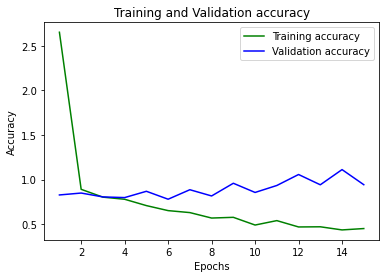

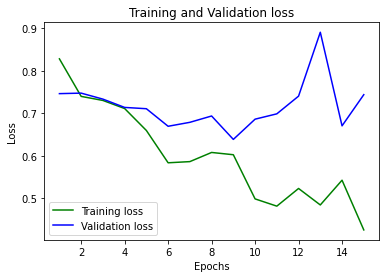

In [190]:
Y_pred = model.predict_generator(test_generator, (9296 / 20)) # ceil(num_of_test_samples / batch_size)
target_names = ['Men', 'Woman','Baby']
print(classification_report(test_generator.classes[:Y_pred.shape[0]],
                            list(np.argmax(Y_pred,axis=1)), 
                            target_names=target_names))


acc_train = history.history['acc']
acc_val = history.history['val_acc']
epochs = range(1,16)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,16)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

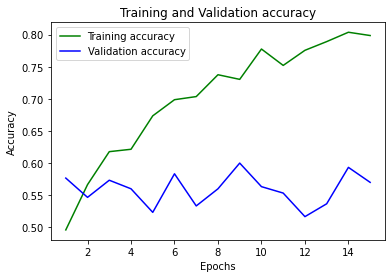

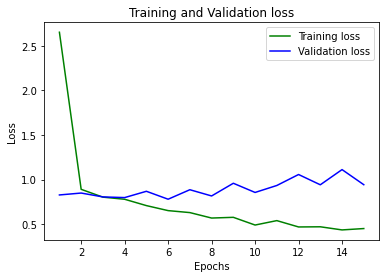